In [1]:
import re
import nltk
from string import punctuation
import pandas as pd
from collections import defaultdict
import os
import io
import math
import matplotlib.pyplot as plt
import sys

# Funções de pré-processamento de texto

In [2]:
def text_lowercase(text):
    return text.lower()

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_double_periods(text): 
    return re.sub(r'( *\. *(\. *)*)+', ' . ', text)

def remove_punctuation(text):
    symbols_pattern = r'[!"#\$%&\'\(\)\*\+,\-\–\/:=\?@\[\\\]\^_`{\|}~º(...)]'
    text = re.sub(symbols_pattern, ' ', text)
    return text

def remove_multiple_whitespace(text):
    return re.sub(' +', ' ', text)

def remove_stopwords(text):
    stop_words = set(nltk.corpus.stopwords.words('portuguese'))
    tokens = nltk.tokenize.word_tokenize(text)
    clean_text = [token for token in tokens if token not in stop_words]
    return ' '.join(clean_text)

def replace_linebreak_with_period(text):
    return re.sub(r' *\n *', ' . ', text)

def insert_tags(text): 
    text = '<s> <s> ' + text
    text = re.sub(r' *(?<!^)\. *(?!$)| *; *', ' </s> </s> <s> <s> ', text)
    return re.sub(' *\. *$', ' </s> </s> ', text)

def remove_empty_sentences(text):
    return re.sub('<s>\s*<s>\s*<\/s>\s*<\/s>', '', text)

def preprocess_text(text):
    text = text_lowercase(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = replace_linebreak_with_period(text)
    text = remove_multiple_whitespace(text)
    text = text + '.' # insert final period just in case
    text = remove_double_periods(text)
    text = remove_stopwords(text)
    text = insert_tags(text)
    text = remove_empty_sentences(text)
    return text

# Treinamento do Modelo 3-Gram com Interpolação

In [3]:
three_gram = defaultdict(lambda : defaultdict(int))
bi_gram = defaultdict(lambda : defaultdict(int))
uni_gram = defaultdict(int)
vocabulary = set()
word_count = 0
tags = ['<s>', '</s>']

def filter_words(word):
    return word not in tags

def proccess_dataset():
    files = os.listdir(os.getcwd() + "/CHAVEFolha/folha95")
    total = len(files)
    for index, file_name in enumerate(files):
        print(f'processing file {index+1} of {total}\r', sep=' ', end='', flush=True)
        f = io.open(os.getcwd() + "\\CHAVEFolha\\folha95\\" + file_name, mode="r", encoding="latin-1")
        file_content = f.read()
        texts = re.findall("(?<=<TEXT>\n)[\w\W]+?(?=<\/TEXT>)", file_content)

        for text in texts: 
            preprocessed_text = preprocess_text(text)
            build_tables(preprocessed_text)

def build_tables(preprocessed_text):
    global word_count, vocabulary
    #for sentence in re.findall('(?<=<s><s>)[\w\W]*?(?=<\/s><\/s>)', preprocessed_text):
    for sentence in re.findall('\s*<s>\s*<s>\s*.+?\s*<\/s>\s*<\/s>\s*', preprocessed_text):
        words = sentence.split()
        word_count += len(words)
        
        for word in words:
            vocabulary.add(word)
            uni_gram[word] += 1
            
        for index in range(len(words) - 1):
            word1 = words[index]
            word2 = words[index+1]
            bi_gram[word1][word2] += 1
        
        for index in range(len(words) - 2):
            word1 = words[index]
            word2 = words[index+1]
            word3 = words[index+2]
            three_gram[f'{word1} {word2}'][word3] += 1
            
proccess_dataset()

# Função para calcular a probabilidade

In [4]:
def calculate_probability(word3, word1, word2):    
    three_gram_probability =  (three_gram[f'{word1} {word2}'][word3] / bi_gram[word1][word2]) if bi_gram[word1][word2] > 0 else 0
    bi_gram_probability =  (bi_gram[word2][word3] / uni_gram[word2]) if uni_gram[word2] > 0 else 0
    uni_gram_probability = uni_gram[word3] / len(vocabulary)
    
    probability = 0.5 * three_gram_probability + 0.3 * bi_gram_probability + 0.2 * uni_gram_probability
    return probability if probability > 0.0 else sys.float_info.min

# Testando contra o dataset folha94

In [5]:
per_sentence_perplexity = defaultdict(int)
sentences = []

test_files = os.listdir(os.getcwd() + "/CHAVEFolha/folha94")
total = len(test_files)
    
for index, file_name in enumerate(test_files):
    print(f'processing file {index+1} of {total}\r', sep=' ', end='', flush=True)
    f = io.open(os.getcwd() + "\\CHAVEFolha\\folha94\\" + file_name, mode="r", encoding="latin-1")
    file_content = f.read()
    texts = re.findall("(?<=<TEXT>\n)[\w\W]+?(?=<\/TEXT>)", file_content)

    for text in texts:
        preprocessed_text = preprocess_text(text)
        for sentence in re.findall('\s*<s>\s*<s>\s*.+?\s*<\/s>\s*<\/s>\s*', preprocessed_text):
            words = sentence.split()
            probability = 0

            for index in range(len(words) - 2):
                word1 = words[index]
                word2 = words[index+1]
                word3 = words[index+2]
                
                _probability = calculate_probability(word3, word1, word2)
                probability += math.log(_probability)
            per_sentence_perplexity[sentence] = math.exp(probability)**(-1/float(len(words))) if math.exp(probability) > 0.0 else math.inf

In [6]:
values = per_sentence_perplexity.values()

In [7]:
sorted_perplexity = {k: v for k, v in sorted(per_sentence_perplexity.items(), key=lambda item: item[1])}

In [13]:
values = sorted_perplexity.values()
plot_perplex = list(filter(lambda item: item < math.inf, values))

In [14]:
average_perplex = sum(plot_perplex) / len(plot_perplex)
average_perplex

2.9626832243321677e+58

In [15]:
sum(plot_perplex) / len(plot_perplex)

2.9626832243321677e+58

In [16]:
plot_probabilities = [1 / value for value in values]

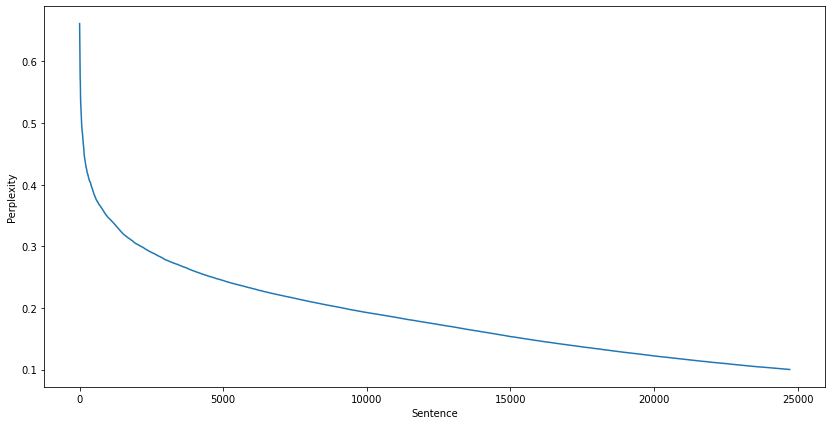

In [17]:
plt.figure(figsize=(14,7))
plt.xlabel('Sentence')
plt.ylabel('Perplexity')

data = list(filter(lambda value: value > 0.1, plot_probabilities))
plt.plot(data)

(array([10062.,  6858.,  4292.,  2087.,   891.,   337.,   118.,    49.,
           19.,    13.]),
 array([0.10000952, 0.15613624, 0.21226296, 0.26838968, 0.3245164 ,
        0.38064311, 0.43676983, 0.49289655, 0.54902327, 0.60514999,
        0.66127671]),
 <BarContainer object of 10 artists>)

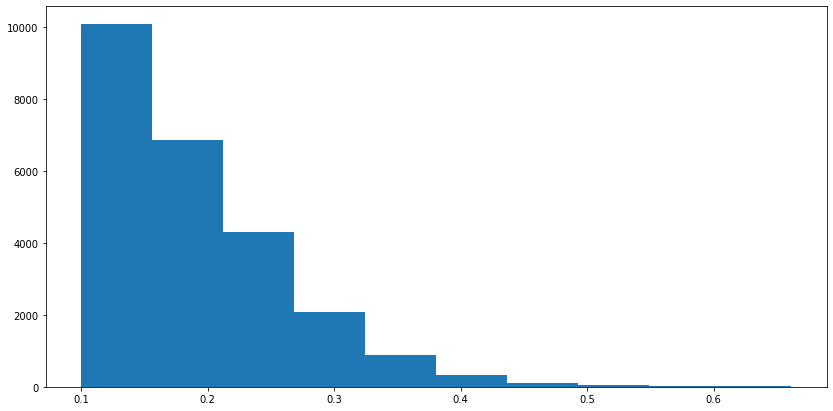

In [18]:
plt.figure(figsize=(14,7))
plt.hist(data)